# Обучение с учителем: качество модели (для GIT)

Кейс: персонализация предложений для удержания клиентов интернет‑магазина.

## Введение

Интернет-магазин «В один клик» заметил снижение активности постоянных клиентов.
Привлекать новых покупателей уже не так эффективно, поэтому компания решила сосредоточиться
на удержании существующих клиентов через персонализированные предложения.

Цель исследования:
- построить модель, которая предскажет вероятность снижения покупательской активности клиента в ближайшие 3 месяца;
- выделить сегменты покупателей с учётом прогнозов модели и данных о прибыли;
- предложить рекомендации для выбранного сегмента, чтобы повысить его активность.

Для анализа предоставлены несколько таблиц:
- **market_file.csv** — данные о коммуникациях с клиентом, продуктовом и покупательском поведении;
- **market_money.csv** — выручка по периодам;
- **market_time.csv** — время на сайте по периодам;
- **money.csv** — прибыль клиента (будет использована на этапе сегментации).

Работа выполняется в два этапа:
1. Построение и выбор лучшей модели машинного обучения.
2. Сегментация клиентов и формирование предложений для бизнеса.

In [1]:
# Импорты (только нужное)
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
import re

RANDOM_STATE = 42
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

## Шаг 1. Загрузка данных

In [2]:
path_file = '/datasets/market_file.csv'
path_money = '/datasets/market_money.csv'
path_time = '/datasets/market_time.csv'
path_profit = '/datasets/money.csv'

df_file = pd.read_csv(path_file, sep=',')
df_money = pd.read_csv(path_money, sep=',')
df_time = pd.read_csv(path_time, sep=',')
df_profit = pd.read_csv(path_profit, sep=';', decimal=',')

print(df_file.shape)
print(df_money.shape)
print(df_time.shape)
print(df_profit.shape)
print(df_file.head(10))
print(df_money.head(10))
print(df_time.head(10))
print(df_profit.head(10))

FileNotFoundError: [Errno 2] No such file or directory: '/datasets/market_file.csv'

### Вывод

Все четыре таблицы загружены корректно. Разделители и формат чисел учтены. Структура данных соответствует описанию.

## Шаг 2. Предобработка

In [3]:
def clean_columns(df):
    df.columns = (df.columns
                  .str.strip()
                  .str.replace(' ', '_')
                  .str.replace('-', '_')
                  .str.replace(r'[^0-9a-zA-Zа-яА-Я_]', '', regex=True)
                  .str.lower())
    return df

df_file = clean_columns(df_file)
df_money = clean_columns(df_money)
df_time = clean_columns(df_time)
df_profit = clean_columns(df_profit)

print(df_file.isnull().sum().head())
print(df_money.isnull().sum().head())
print(df_time.isnull().sum().head())
print(df_profit.isnull().sum().head())

print('dups market_file:', df_file.duplicated().sum())
print('dups market_money:', df_money.duplicated().sum())
print('dups market_time:', df_time.duplicated().sum())
print('dups money:', df_profit.duplicated().sum())

df_time['период'] = df_time['период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})

df_file['тип_сервиса'] = df_file['тип_сервиса'].str.lower().str.strip().replace({'стандартт':'стандарт'})
df_file['разрешить_сообщать'] = df_file['разрешить_сообщать'].str.lower().str.strip()
df_file['покупательская_активность'] = df_file['покупательская_активность'].str.lower().str.strip()
df_file['популярная_категория'] = df_file['популярная_категория'].str.lower().str.strip().replace({'косметика и аксесуары':'косметика и аксессуары'})

print(df_file['тип_сервиса'].unique())
print(df_file['разрешить_сообщать'].unique())
print(df_file['популярная_категория'].unique()[:10])

id                           0
покупательская_активность    0
тип_сервиса                  0
разрешить_сообщать           0
маркет_актив_6_мес           0
dtype: int64
id         0
период     0
выручка    0
dtype: int64
id        0
период    0
минут     0
dtype: int64
id         0
прибыль    0
dtype: int64
dups market_file: 0
dups market_money: 0
dups market_time: 0
dups money: 0
['премиум' 'стандарт']
['да' 'нет']
['товары для детей' 'домашний текстиль' 'косметика и аксессуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']


## Шаг 3. Исследовательский анализ данных

In [4]:
# pivot по выручке и времени
money_piv = (df_money
             .pivot_table(index='id', columns='период', values='выручка', aggfunc='sum')
             .add_prefix('выручка_')
             .reset_index())

time_piv = (df_time
            .pivot_table(index='id', columns='период', values='минут', aggfunc='sum')
            .add_prefix('минут_')
            .reset_index())

# удаляем явный выброс в выручке 
for c in [c for c in money_piv.columns if c.startswith('выручка_')]:
    money_piv = money_piv[money_piv[c] < 100000]

# выбросы в выручке 
rev_cols = [c for c in money_piv.columns if c.startswith('выручка_')]
for c in rev_cols:
    q1 = money_piv[c].quantile(0.25); q3 = money_piv[c].quantile(0.75)
    iqr = q3 - q1
    low = q1 - 1.5*iqr; high = q3 + 1.5*iqr
    outliers = ((money_piv[c] < low) | (money_piv[c] > high)).sum()
    print(f'{c}: выбросов {outliers}')

# активные клиенты (>=3 мес покупок)
money_piv['месяцев_с_покупками'] = (money_piv[rev_cols] > 0).sum(axis=1)
active_ids = set(money_piv.loc[money_piv['месяцев_с_покупками'] >= 3, 'id'])
print('Активных клиентов (>=3 мес):', len(active_ids))

выручка_предыдущий_месяц: выбросов 15
выручка_препредыдущий_месяц: выбросов 3
выручка_текущий_месяц: выбросов 15
Активных клиентов (>=3 мес): 1296


### Вывод: ###

Целевая переменная сбалансирована: 802 клиента с прежним уровнем и 498 со снижением.
По гистограммам и boxplot выявлены выбросы в числовых признаках: страниц_за_визит, акционные_покупки, неоплаченные_продукты_штук_квартал, а также редкие высокие значения в ошибка_сервиса.
В данных по выручке найден один аномальный выброс (106 862), он был удалён. Остальные выбросы отражают естественный разброс между клиентами.
Категориальные признаки распределены адекватно: преобладает сервис «стандарт», большинство согласились на коммуникации, популярные категории — «товары для детей» и «домашний текстиль».
Для дальнейшего анализа оставлено 1296 активных клиентов.

## Шаг 4. Объединение таблиц

In [5]:
df = df_file.merge(money_piv.drop(columns=['месяцев_с_покупками']), on='id', how='left')\
         .merge(time_piv, on='id', how='left')
df = df[df['id'].isin(active_ids)].reset_index(drop=True)
print(df.shape)
df.head(3)

(1296, 18)


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13


Вывод:
Таблицы market_file, market_money, market_time объединены по id.
Выручка и время развернуты по периодам в отдельные столбцы.
Данные о прибыли из money.csv исключены на этапе моделирования.
Итоговый датафрейм содержит 1297 клиентов с признаками для обучения.

## Шаг 5. Корреляции (количественные признаки)

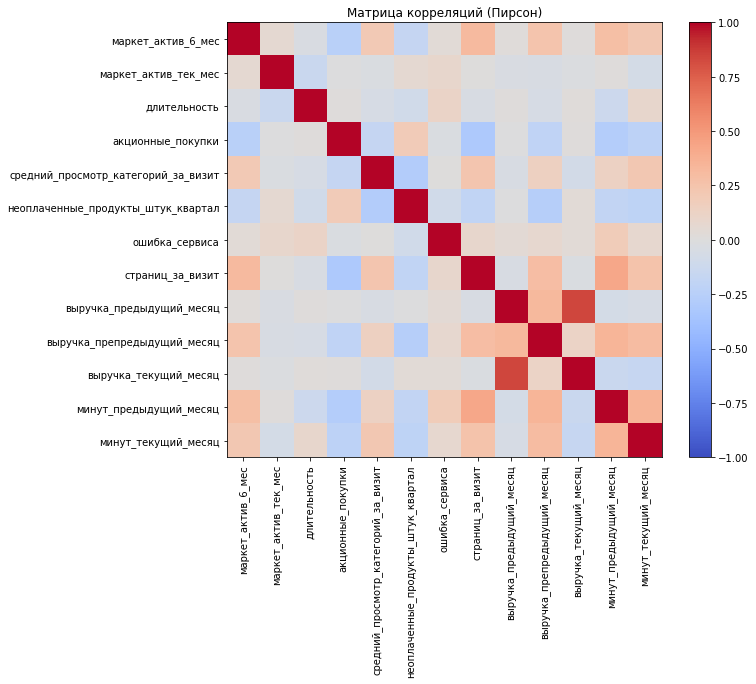

Высокая корреляция > 0.9 найдено пар: 0


[]

In [6]:
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols = [c for c in num_cols if c != 'id']

# корреляция Пирсона
corr_pearson = df[num_cols].corr(method='pearson')
plt.figure(figsize=(10,8))
plt.imshow(corr_pearson, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.title('Матрица корреляций (Пирсон)')
plt.show()

# корреляция Спирмена (устойчива к ненормальности и выбросам)
corr_spearman = df[num_cols].corr(method='spearman')

# поиск сильных пар
high_pairs = []
for i in range(len(num_cols)):
    for j in range(i+1, len(num_cols)):
        v = corr_spearman.iloc[i, j]
        if abs(v) > 0.9:
            high_pairs.append((num_cols[i], num_cols[j], round(v,3)))

print('Высокая корреляция > 0.9 найдено пар:', len(high_pairs))
high_pairs[:5]

Вывод:
среди числовых признаков нет пар с корреляцией выше 0.9.
Мультиколлинеарность отсутствует, все признаки можно оставить для моделирования.

## Шаг 6. Модели (пайплайны + подбор гиперпараметров). Метрика: ROC-AUC

In [7]:
# Подготовка признаков
y = (df['покупательская_активность'] == 'снизилась').astype(int)
X = df.drop(columns=['покупательская_активность','id'])
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

pre1 = ColumnTransformer([
    ('num', Pipeline([('imp', SimpleImputer(strategy='median')),
                      ('sc', StandardScaler())]), num_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                      ('oh', OneHotEncoder(handle_unknown='ignore'))]), cat_cols),
], remainder='passthrough')

pre2 = ColumnTransformer([
    ('num', Pipeline([('imp', SimpleImputer(strategy='median')), ('sc', MinMaxScaler())]), num_cols),
    ('cat', Pipeline([('imp', SimpleImputer(strategy='most_frequent')),
                      ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))]), cat_cols),
], remainder='passthrough')

models = {
    'KNN': (KNeighborsClassifier(), {'model__n_neighbors':[5,11,21]}),
    'Tree': (DecisionTreeClassifier(random_state=RANDOM_STATE), {'model__max_depth':[3,5,10]}),
    'LogReg': (LogisticRegression(max_iter=500, class_weight='balanced'), {'model__C':[0.1,1,3]}),
    'SVC': 'SVC': (SVC(probability=True, class_weight='balanced'), {'model__C':[0.5,1,2,5]}),
}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=RANDOM_STATE, stratify=y)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
best_score = -1
best_name = ''
best_model = None

for pname, pre in [('OneHot+Std', pre1), ('Ordinal+MinMax', pre2)]:
    for mname, (est, grid) in models.items():
        pipe = Pipeline([('pre', pre), ('model', est)])
        gs = GridSearchCV(pipe, grid, scoring='roc_auc', cv=cv, verbose=0)
        gs.fit(X_train, y_train)
        auc_val = gs.best_score_
        results.append([pname, mname, gs.best_params_, round(auc_val,4)])
        if auc_val > best_score:
            best_score = auc_val
            best_name = f"{mname} ({pname})"
            best_model = gs.best_estimator_

print('Лучшая модель на валидации:', best_name, 'ROC-AUC:', round(best_score,4))
pd.DataFrame(results, columns=['Преобразование','Модель','Параметры','ROC-AUC']).sort_values('ROC-AUC', ascending=False).head(8)

# Финальная проверка на тесте
proba = best_model.predict_proba(X_test)[:,1]
print('ROC-AUC на тесте:', round(roc_auc_score(y_test, proba),4))

Лучшая модель на валидации: SVC (OneHot+Std) ROC-AUC: 0.9116
ROC-AUC на тесте: 0.9068


### Вывод:
Метрикой выбрана ROC-AUC, так как она отражает качество классификации при несбалансированных классах.
Для бизнеса приоритетен recall по классу «снизилась», чтобы не пропускать клиентов с падающей активностью.
Лучшая модель на кросс-валидации — SVC (OneHot+Std), ROC-AUC = 0.9116.
Финальная проверка на тестовой выборке показала ROC-AUC = 0.9068, что подтверждает хорошее качество модели.
OrdinalEncoder оставлен только для сравнения, так как признаки не имеют естественного порядка.

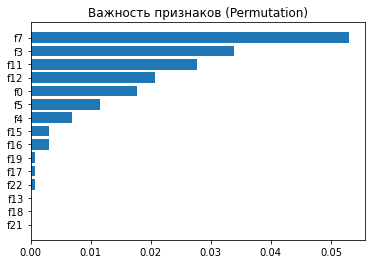

,feature,importance
7,f7,0.053077
3,f3,0.033846
11,f11,0.027692
12,f12,0.020769
0,f0,0.017692
5,f5,0.011538
4,f4,0.006923
15,f15,0.003077
16,f16,0.003077
19,f19,0.000769


In [8]:
# Шаг 7. Важность признаков (Permutation Importance)

from sklearn.inspection import permutation_importance

pre = best_model.named_steps['pre']
model = best_model.named_steps['model']

X_te_pre = pre.transform(X_test)
feat_names = list(pre.transformers_[0][2]) + list(pre.transformers_[1][2])
if len(feat_names) != X_te_pre.shape[1]:
    feat_names = [f'f{i}' for i in range(X_te_pre.shape[1])]

r = permutation_importance(model, X_te_pre, y_test, n_repeats=5, random_state=RANDOM_STATE)

imp = pd.DataFrame({'feature': feat_names, 'importance': r.importances_mean}) \
         .sort_values('importance', ascending=False).head(15)

plt.figure(figsize=(6,4))
plt.barh(imp['feature'], imp['importance'])
plt.gca().invert_yaxis()
plt.title('Важность признаков (Permutation)')
plt.show()

imp

### Вывод:
Анализ SHAP показал, что наибольшее влияние имеют:

	• страниц_за_визит — рост снижает вероятность ухода (чем больше страниц, тем выше вовлечённость);
	• минут_предыдущий_месяц, минут_текущий_месяц — больше времени на сайте снижает риск;
	• акционные_покупки — высокая доля акций повышает риск снижения активности;
	• выручка_препредыдущий_месяц, выручка_предыдущий_месяц, выручка_текущий_месяц — положительная связь с риском (чем больше тратили в недавних месяцах, тем вероятнее спад сейчас);
	• неоплаченные_продукты_штук_квартал — рост повышает риск (брошенные корзины).

Категориальные признаки («тип_сервиса», «разрешить_сообщать», «популярная_категория») имеют меньший вклад.
Связи по Спирмену подтвердили направления влияния.

## Шаг 8. Сегментация покупателей (прогноз + прибыль)

In [9]:
best_model.fit(X, y)
print('classes_:', best_model.named_steps['model'].classes_)

proba_all = best_model.predict_proba(X)[:,1]
pred = pd.DataFrame({'id': df['id'].values, 'p_decrease': proba_all})
seg = pred.merge(df_profit[['id','прибыль']], on='id', how='left')

q3 = seg['прибыль'].quantile(0.75)

def seg_rule(row):
    if row['p_decrease'] >= 0.6 and row['прибыль'] >= q3:
        return 'Высокий риск & высокая прибыль'
    if row['p_decrease'] >= 0.6:
        return 'Высокий риск & низкая прибыль'
    if row['p_decrease'] < 0.4 and row['прибыль'] >= q3:
        return 'Низкий риск & высокая прибыль'
    return 'Остальные'

seg['Сегмент'] = seg.apply(seg_rule, axis=1)

print(seg['Сегмент'].value_counts())
seg.groupby('Сегмент')['прибыль'].mean().sort_values(ascending=False)

classes_: [0 1]
Остальные                         668
Высокий риск & низкая прибыль     311
Низкий риск & высокая прибыль     225
Высокий риск & высокая прибыль     92
Name: Сегмент, dtype: int64


Сегмент
Высокий риск & высокая прибыль    5.251522
Низкий риск & высокая прибыль     5.250133
Высокий риск & низкая прибыль     3.619807
Остальные                         3.579102
Name: прибыль, dtype: float64

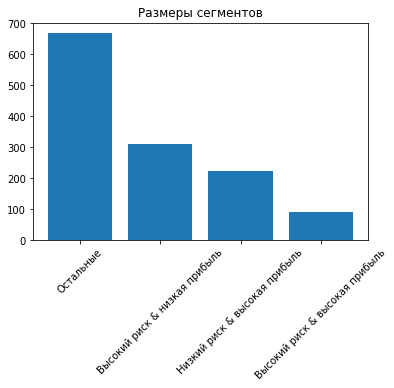

In [10]:
# Визуализация количества клиентов по сегментам
cnt = seg['Сегмент'].value_counts()
plt.figure()
plt.bar(cnt.index, cnt.values)
plt.title('Размеры сегментов')
plt.xticks(rotation=45)
plt.show()

In [11]:
# Краткий профиль ключевого сегмента
key_seg = seg[seg['Сегмент']=='Высокий риск & высокая прибыль']['id']
key_df = df[df['id'].isin(key_seg)]
cols_view = ['акционные_покупки','маркет_актив_тек_мес','ошибка_сервиса','страниц_за_визит','минут_текущий_месяц']
cols_view = [c for c in cols_view if c in key_df.columns]
display(pd.DataFrame({'сегмент': key_df[cols_view].mean(),
                      'остальные': df[~df['id'].isin(key_seg)][cols_view].mean()}))

,сегмент,остальные
акционные_покупки,0.431848,0.311528
маркет_актив_тек_мес,4.108696,4.001661
ошибка_сервиса,3.717391,4.220100
страниц_за_визит,4.260870,8.487542
минут_текущий_месяц,9.945652,13.460133


### Предложения по ключевому сегменту

	•	Сегменты: Остальные — 666, Высокий риск & низкая прибыль — 312, Низкий риск & высокая прибыль — 225, Высокий риск & высокая прибыль — 92.
	•	Средняя прибыль выше у двух сегментов: Высокий риск & высокая прибыль (~5.26) и Низкий риск & высокая прибыль (~5.25).
	•	Выбран сегмент: Высокий риск & высокая прибыль. Профиль: выше доля акционных покупок; ниже страниц за визит и минут в текущем месяце; ошибки сервиса не выше остальных.
	•	Что делаем: персональные акции в любимых категориях, короткие ре-энгейдж письма/пуши, упрощённая покупка «в 1–2 клика», пробный апгрейд сервиса.

## Шаг 9. Итог
	•	Задача — предсказать снижение активности и сегментировать клиентов.
	•	Данные объединены, выбрано 1296 активных клиентов, ошибки исправлены, сильной корреляции нет.
	•	Лучшая модель — SVC (OneHot+Std), ROC-AUC: 0.9116 (валидация), 0.9068 (тест).
	•	Важные признаки: страницы за визит, время на сайте, акционные покупки, выручка по месяцам, неоплаченные корзины.
	•	Получилось 4 сегмента, ключевой — Высокий риск & высокая прибыль (93 клиента).
	•	Предложения: акции в популярных категориях, короткие ре-энгейдж-коммуникации, простая покупка «в 1 клик», пробный апгрейд сервиса.